# Transfer learning - Cats vs. Dogs

Code to initiliaze Tensorflow 2.0 in Colab

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
import os

**[TODO] Create a data loader function that returns a tuple with a tf.float32 tensor for the image and a label. Images must be resized to 128x128.**
**N.B.: filenames are formatted as class.number.jpg**

In [82]:
def load_image(img_path, resize_to=None):
    # read the image from disk, decode it, convert the data type to
    # floating point, and resize it
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    if resize_to is not None:
        image = tf.image.resize(image, resize_to, method=tf.image.ResizeMethod.AREA)
        # image = tf.image.resize_with_crop_or_pad(image, resize_to)
    # parse the class label from the file path
    fn_img = tf.strings.split(img_path, sep='/')[-1]
    label = tf.strings.split(fn_img, sep='.')[0]
    label = tf.strings.to_number(label, tf.float32)

    # return the image and the label
    return image, label

def load_dataset(folder):
    features_list = []
    labels_list = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            filepath = os.path.join(folder, filename)
            features, label = load_image(filepath, resize_to=(128, 128))
            features_list.append(features)
            labels_list.append(label)
    ds_features = tf.data.Dataset.from_tensor_slices(features_list)
    ds_labels = tf.data.Dataset.from_tensor_slices(labels_list)
    return tf.data.Dataset.zip((ds_features, ds_labels))

**[TODO] Create a tf.Dataset, map the loader function and prepare a batch object for training**

In [3]:
# Datasets creation
# 0 -> cats; 1 -> dogs
ds_train = load_dataset('./train/')
ds_test = load_dataset('./test/')

In [8]:
# Batch preparation
ds_train = ds_train.batch(batch_size=32)
# ds_train = ds_train.shuffle(128)
ds_test = ds_test.batch(batch_size=32)
# ds_test = ds_test.shuffle(128)

**Prepare Keras callback for Tensorboard**

In [9]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, update_freq='batch')

**[TODO] Import the MobileNetV2 model trained on ImageNet without the final layer**

In [10]:
mnv2 = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(128, 128, 3), include_top=False, classes=2)
mnv2.trainable = False

**[TODO] Add a final classification layer for 2 classes and create the final Keras model**

In [11]:
inputs = tf.keras.Input(shape=(128, 128, 3))
h = mnv2(inputs, training=False)
# h = tf.keras.layers.GlobalAveragePooling2D()(h)
h = tf.keras.layers.Flatten()(h)
# h = tf.keras.layers.Dropout(0.2)(h)
classifier = tf.keras.layers.Dense(2, activation='softmax')(h)

**[TODO] Compile the Keras model: specify the optimization algorithm, the loss function and the test metric**

In [12]:
model = tf.keras.Model(inputs=inputs, outputs=classifier)
model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

**[TODO] Train the Keras model**

In [13]:
model.fit(ds_train, epochs=6)

Epoch 1/6
63/63 [==============================] - 17s 202ms/step - loss: 59.3738 - accuracy: 0.8745
Epoch 2/6
63/63 [==============================] - 13s 199ms/step - loss: 228.6618 - accuracy: 0.7015
Epoch 3/6
63/63 [==============================] - 13s 213ms/step - loss: 33.3714 - accuracy: 0.9105
Epoch 4/6
63/63 [==============================] - 14s 226ms/step - loss: 10.8768 - accuracy: 0.9550
Epoch 5/6
63/63 [==============================] - 14s 220ms/step - loss: 6.0838 - accuracy: 0.9695
Epoch 6/6
63/63 [==============================] - 14s 223ms/step - loss: 3.6251 - accuracy: 0.9765


**[TODO] Print model summary**

In [14]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0         
                                                                 
 dense_1 (Dense)             (None, 2)                 40962     
                                                                 
Total params: 2298946 (8.77 MB)
Trainable params: 40962 (160.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
None


**[TODO] Test the Keras model by computing the accuracy the whole test set**

In [15]:
model.evaluate(ds_test)

32/32 [==============================] - 9s 223ms/step - loss: 8.8151 - accuracy: 0.9530


[8.815067291259766, 0.953000009059906]

**[TODO] Load Test image 'test/0.1047.jpg', visualize it and check the network prediction**

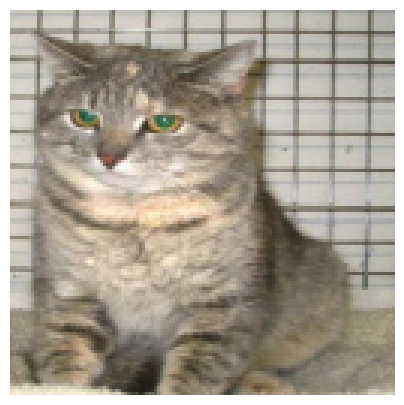

In [74]:
# Showing the image
data, label = load_image('./test/0.1047.jpg', resize_to=(128, 128))
ds_img_data = tf.data.Dataset.from_tensor_slices([data])
plt.figure(figsize=(5, 5))
plt.imshow(data)
plt.axis('off')
plt.show()

In [17]:
# Predicting it
ds_img_data = tf.data.Dataset.from_tensor_slices([data])
model.predict(ds_img_data.batch(16))

1/1 [==============================] - 2s 2s/step


array([[1., 0.]], dtype=float32)